We trying

Research Diary: https://drive.google.com/open?id=1zBXLaCameGhHj8RbXeGkep6_gZnUAiAnhGrVE1aEr-4

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import sklearn as sk
import scipy as sp
from scipy import signal
from copy import deepcopy
import math

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
# Force divider function
def force_divider(x):
    k_outer = 3.738
    k_inner = 0.368
    dist = x/k_inner
    return (k_outer + k_inner)*dist

# FSR model function
def FSR_model(x):
    return 131.2*np.exp(0.7801*x)/1000

# Total impulse function for a single matrix of data 
# Iterates over data and computes the total impulse for all sensors over time
def impulse(data_matrix): 
    fsr_data = data_matrix
    impulse = 0
    for col in range(0, 12):
        single_FSR = data_matrix[:,col]
        for i in range(0, 1000):
            averagef = (single_FSR[i+1] + single_FSR[i])/2 
            impulse = impulse + averagef
    return impulse 

# Return a numpy array containing the differential between consecutive elements (approximation of slope) 
# in a given data array
def slope(dataVector):
    dydx = []
    for i in range(1, len(dataVector)):
        diff = dataVector[i] - dataVector[i-1]
        dydx.append(diff)
    finalDiff = dataVector[i] - dataVector[i-1] # Added just to make the final array the proper dimensions 
    dydx.append(finalDiff)
    return np.array(dydx)

# Return a numpy array containing the value and index of the largest magnitude value in given data array (first instance)
def largest(dataVector):
    val = max(abs(dataVector))
    ind = 0
    for k in dataVector:
        if abs(k) == val:
            return np.array([val, ind])
        else:
            ind += 1

In [3]:
# Labels
    # Fall = 1
    # Impact = 2
    # Nothing = 3
    # Squeeze = 4
    
# Add Fall data
string = "/Users/alber/Desktop/BEST/Tensegrity-HRI/DataV2/fall"
numbers = np.arange(1,15)
fsrData = []
accelData = []
totData = []
for num in numbers:
    filename = string + str(num) + '.csv'
    d = pd.read_csv(filename, names = ["IND", "time", "FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", 
                                               "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12",
                                              "ACC_X", "ACC_Y", "ACC_Z"])
    fsrFall = d[["FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", 
                 "FSR_12"]]
    accelFall = d[["ACC_X", "ACC_Y", "ACC_Z"]]
    totFall = d[["FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", 
                 "FSR_12", "ACC_X", "ACC_Y", "ACC_Z"]]
    fsrFall = fsrFall.to_numpy()
    accelFall = accelFall.to_numpy()
    totFall = totFall.to_numpy()
    fsrData.append(fsrFall)
    accelData.append(accelFall)
    totData.append(totFall)

    
# Add Impact data
string = "/Users/alber/Desktop/BEST/Tensegrity-HRI/DataV2/impact"
for num in numbers:
    filename = string + str(num) + '.csv'
    d = pd.read_csv(filename, names = ["IND", "time", "FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", 
                                               "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12",
                                              "ACC_X", "ACC_Y", "ACC_Z"])
    fsrImp = d[["FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", 
                "FSR_12"]]
    accelImp = d[["ACC_X", "ACC_Y", "ACC_Z"]]
    totImp = d[["FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", 
                 "FSR_12", "ACC_X", "ACC_Y", "ACC_Z"]]
    fsrImp = fsrImp.to_numpy()
    accelImp = accelImp.to_numpy()
    totImp = totImp.to_numpy()
    fsrData.append(fsrImp)
    accelData.append(accelImp)
    totData.append(totImp)

    
# Add Nothing data
string = "/Users/alber/Desktop/BEST/Tensegrity-HRI/DataV2/nothing"
for num in numbers:
    filename = string + str(num) + '.csv'
    d = pd.read_csv(filename, names = ["IND", "time", "FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", 
                                               "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12",
                                              "ACC_X", "ACC_Y", "ACC_Z"])
    fsrNoth = d[["FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", 
                 "FSR_12"]]
    accelNoth = d[["ACC_X", "ACC_Y", "ACC_Z"]]
    totNoth = d[["FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", 
                 "FSR_12", "ACC_X", "ACC_Y", "ACC_Z"]]
    fsrNoth = fsrNoth.to_numpy()
    accelNoth = accelNoth.to_numpy()
    totNoth = totNoth.to_numpy()
    fsrData.append(fsrNoth)
    accelData.append(accelNoth)
    totData.append(totNoth)
    
# Add Squeeze data
string = "/Users/alber/Desktop/BEST/Tensegrity-HRI/DataV2/squeeze"
for num in numbers:
    filename = string + str(num) + '.csv'
    d = pd.read_csv(filename, names = ["IND", "time", "FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", 
                                               "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12",
                                              "ACC_X", "ACC_Y", "ACC_Z"])
    fsrSqueeze = d[["FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", 
                 "FSR_12"]]
    accelSqueeze = d[["ACC_X", "ACC_Y", "ACC_Z"]]
    totSqueeze = d[["FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", 
                 "FSR_12", "ACC_X", "ACC_Y", "ACC_Z"]]
    fsrSqueeze = fsrSqueeze.to_numpy()
    accelSqueeze = accelSqueeze.to_numpy()
    totSqueeze = totSqueeze.to_numpy()
    fsrData.append(fsrSqueeze)
    accelData.append(accelSqueeze)
    totData.append(totSqueeze)

#print(np.shape(fsrData))
#print(np.shape(accelData))
#print(np.shape(totData))
#print(fsrData[0][0:10, :])
#print(totData[0][0:10, :])

In [4]:
# Convert fsr data to Newtons
placeHold = []
for m in fsrData:
    m = force_divider(FSR_model(m *5/1023))  
    placeHold.append(m)

for k in totData:
    k[:, 0:12] = force_divider(FSR_model(k[:, 0:12] *5/1023))

fsrData = placeHold
#print(np.shape(totData))
#print(fsrData[0][0:10, :])
#print("\n")
#print(totData[0][0:10, :])

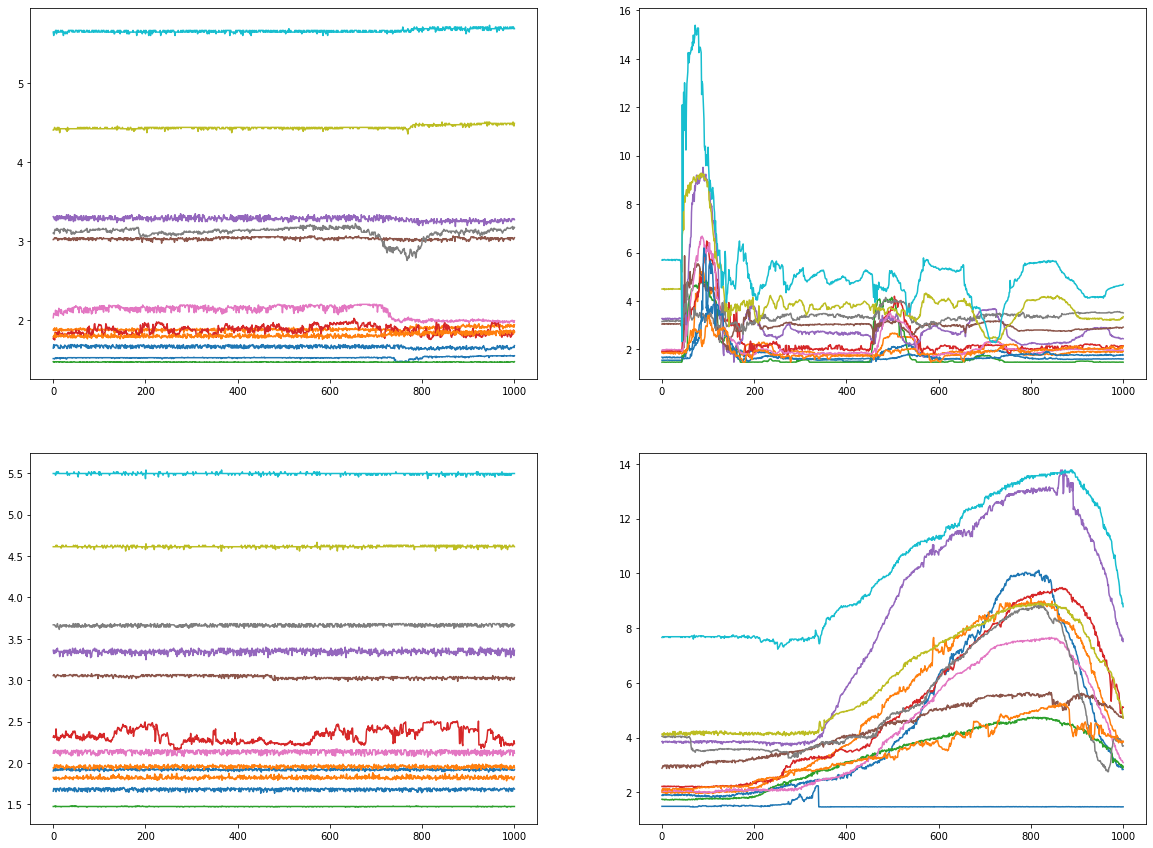

In [5]:
# Plot FSR data (Taking first tests as example)
plt.figure(figsize=(20, 15))
plt.subplot(221)
plt.plot(fsrData[0])
plt.subplot(222)
plt.plot(fsrData[14])
plt.subplot(223)
plt.plot(fsrData[28])
plt.subplot(224)
plt.plot(fsrData[42])

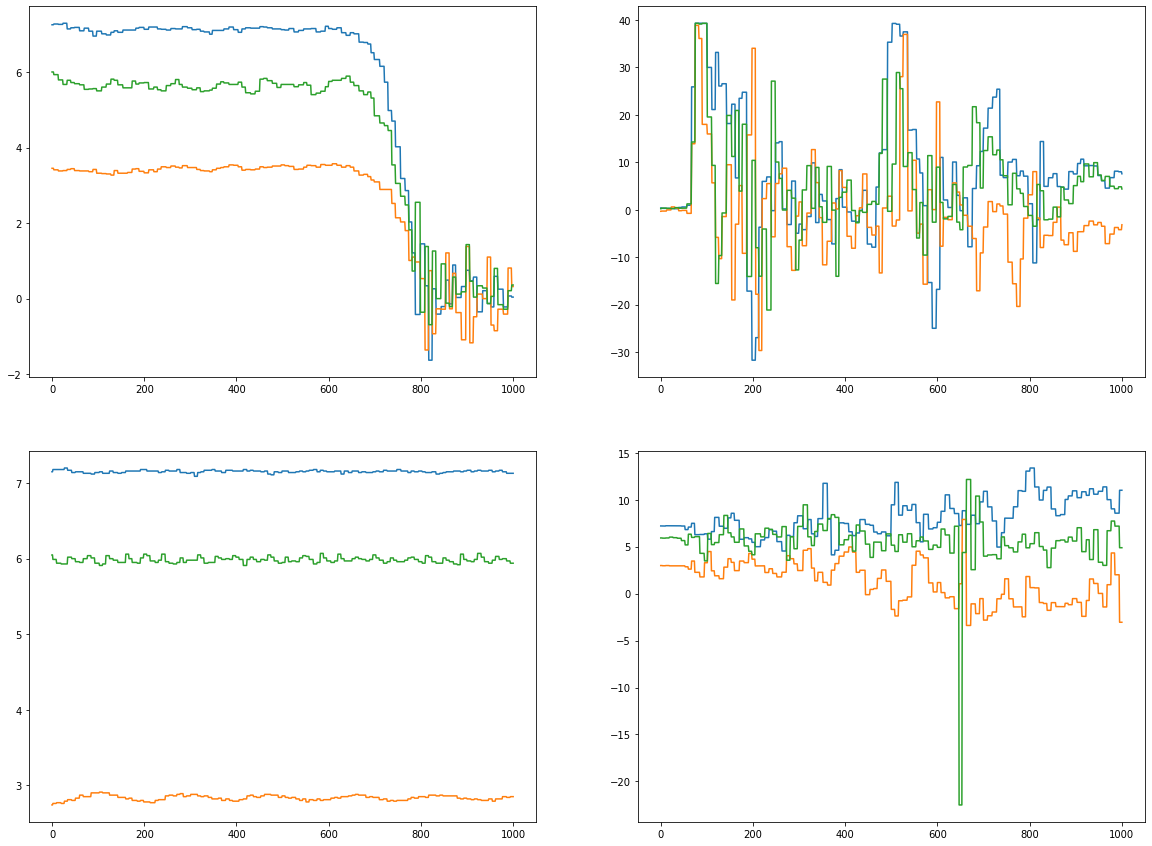

In [6]:
# Plot Accel data
plt.figure(figsize=(20, 15))
plt.subplot(221)
plt.plot(accelData[0])
plt.subplot(222)
plt.plot(accelData[14])
plt.subplot(223)
plt.plot(accelData[28])
plt.subplot(224)
plt.plot(accelData[42])

In [7]:
# Try smoothing out fsr data

fsrRefined = deepcopy(fsrData)

for test in fsrRefined:
    for k in range(0, 12):
        test[:, k] = signal.savgol_filter(test[:, k], 71, 3)       

#plt.figure(figsize = (15,20))
#plt.subplot(211)
#for i in range(0, 12):
#    plt.plot(fsrData[1][:, i])
#plt.subplot(212)
#for i in range(0, 12):
#    plt.plot(fsrRefined[1][:, i])

In [8]:
# Calculate impulse values for eachtest 
impulseVec = []
for test in fsrRefined:
    impulseVal = impulse(test)
    impulseVec.append(impulse)

print(np.shape(impulseVec))

(56,)


In [9]:
# Try smoothing out acceleration data
accelRefined = deepcopy(accelData)

for test in accelRefined:
    for k in range(0, 3):
        test[:, k] = signal.savgol_filter(test[:, k], 71, 3)       

#plt.figure(figsize = (15,20))
#plt.subplot(211)
#for i in range(0, 3):
#    plt.plot(accelData[1][:, i])
#plt.subplot(212)
#for i in range(0, 3):
#    plt.plot(accelRefined[1][:, i])

In [10]:
# Try smoothing out total Data
totRefined = deepcopy(totData)

for test in totRefined:
    for k in range(0, 15):
        test[:, k] = signal.savgol_filter(test[:, k], 71, 3)       

#plt.figure(figsize = (15,20))
#plt.subplot(211)
#for i in range(0, 15):
#    plt.plot(totData[1][:, i])
#plt.subplot(212)
#for i in range(0, 15):
#    plt.plot(totRefined[1][:, i])

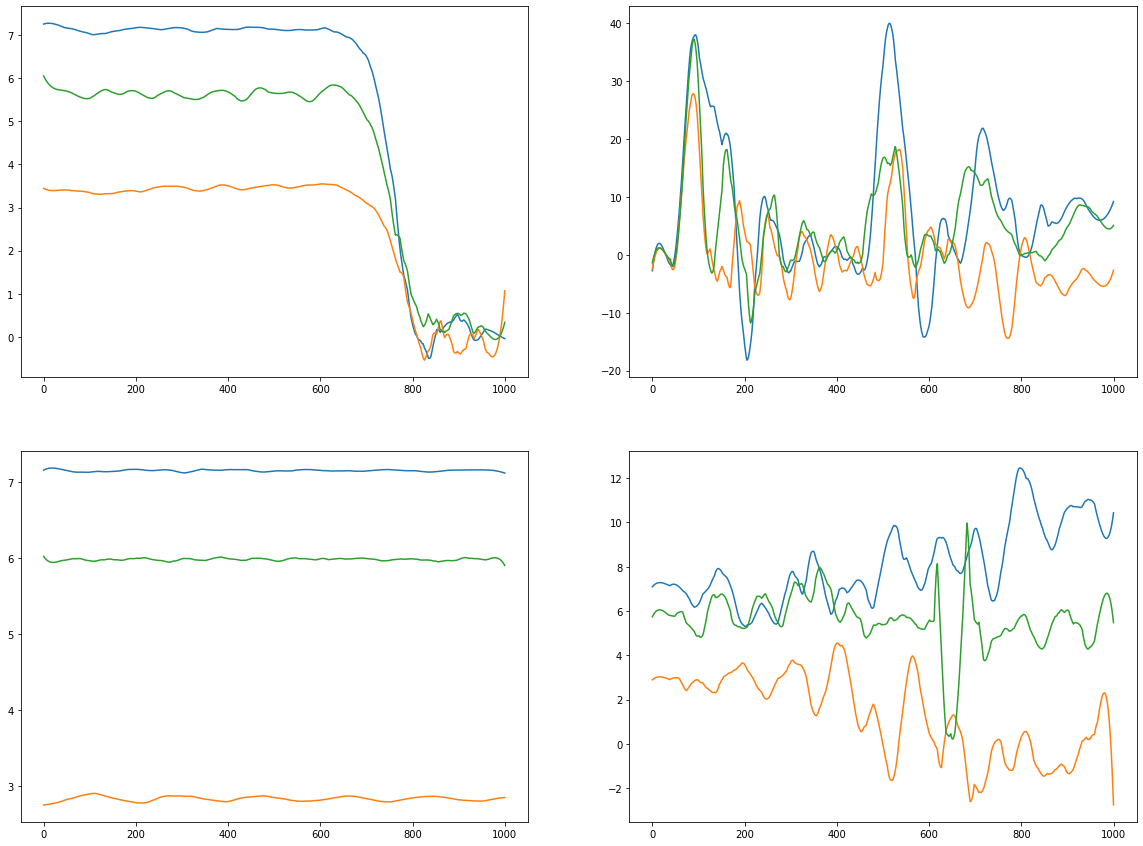

In [11]:
# Look at acceleration data of four types of tests
plt.figure(figsize=(20,15))
plt.subplot(221)
for i in range(0, 3):
    plt.plot(accelRefined[0][:, i])
plt.subplot(222)
for i in range(0, 3):
    plt.plot(accelRefined[14][:, i])  
plt.subplot(223)
for i in range(0, 3):
    plt.plot(accelRefined[28][:, i])  
plt.subplot(224)
for i in range(0, 3):
    plt.plot(accelRefined[42][:, i])  

(56, 1001, 12)
(56, 1001, 3)


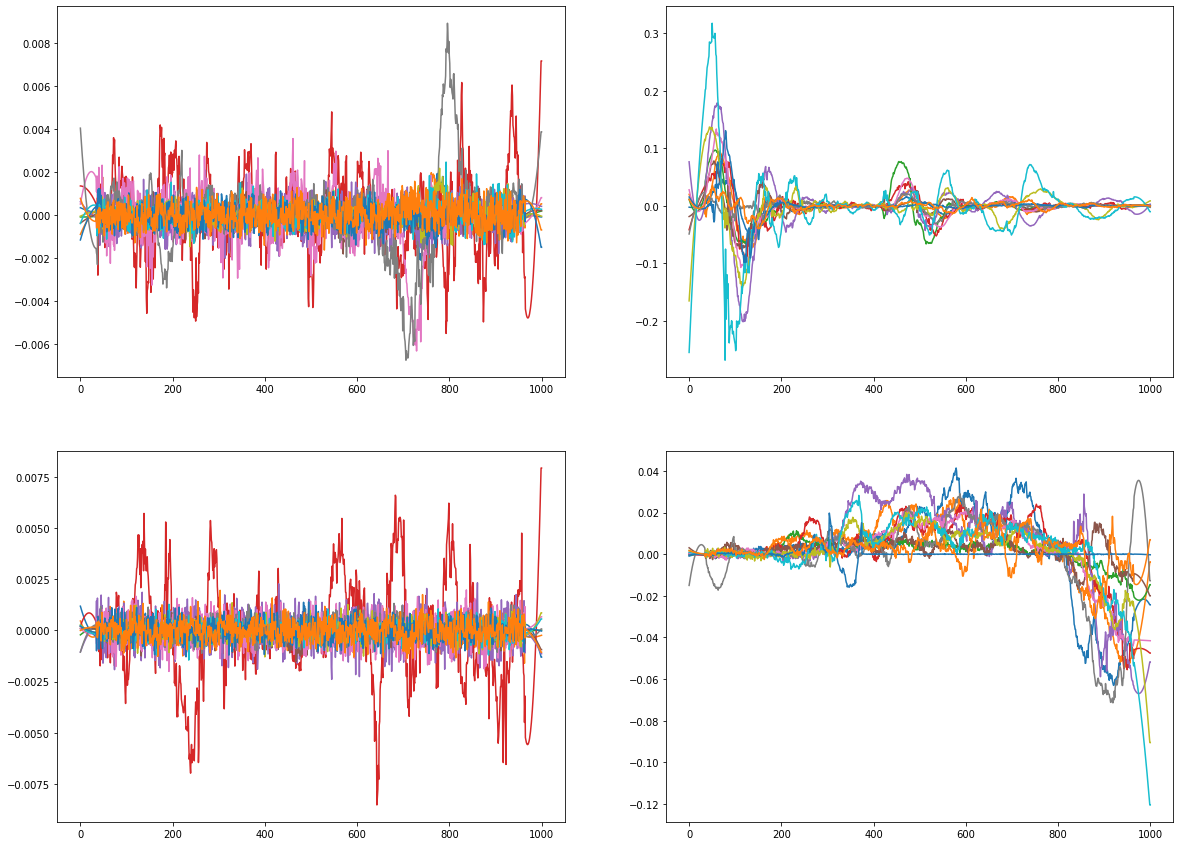

In [12]:
# Generate slope vectors for accel data, plot
accelSlopes = []
for i in range(0, 56):
    accelVec = slope(accelRefined[i])
    accelSlopes.append(accelVec)

# Slope vectors for FSR data
fsrSlopes = []
for i in range(0, 56):
    fsrVec = slope(fsrRefined[i])
    fsrSlopes.append(fsrVec)

print(np.shape(fsrSlopes))
print(np.shape(accelSlopes))

# # Plot acceleration slopes
# plt.figure(figsize=(20,15))
# plt.subplot(221)
# for i in range(0, 3):
#    plt.plot(accelSlopes[0][:, i])
# plt.subplot(222)
# for i in range(0, 3):
#    plt.plot(accelSlopes[14][:, i])  
# plt.subplot(223)
# for i in range(0, 3):
#    plt.plot(accelSlopes[28][:, i])  
# plt.subplot(224)
# for i in range(0, 3):
#    plt.plot(accelSlopes[42][:, i])

# Plot FSR slopes
plt.figure(figsize=(20,15))
plt.subplot(221)
for i in range(0, 12):
   plt.plot(fsrSlopes[0][:, i])
plt.subplot(222)
for i in range(0, 12):
   plt.plot(fsrSlopes[14][:, i])  
plt.subplot(223)
for i in range(0, 12):
   plt.plot(fsrSlopes[28][:, i])  
plt.subplot(224)
for i in range(0, 12):
   plt.plot(fsrSlopes[42][:, i])  

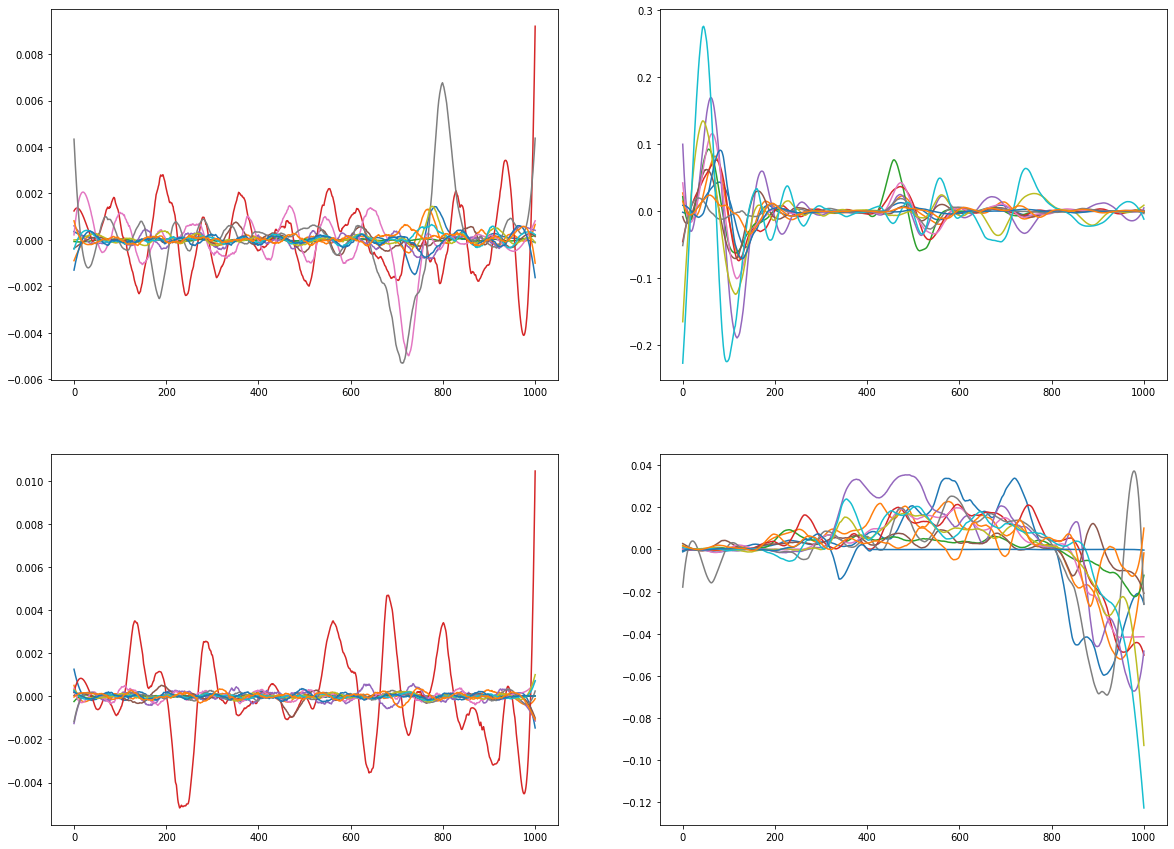

In [13]:
# Clean acceleration slope data
slopeRefined = deepcopy(accelSlopes)

for test in slopeRefined:
    for k in range(0, 3):
        test[:, k] = signal.savgol_filter(test[:, k], 71, 3)  

# Clean FSR slope data
fsrSlopeRef = deepcopy(fsrSlopes)
for test in fsrSlopeRef:
    for k in range(0, 12):
        test[:, k] = signal.savgol_filter(test[:, k], 71, 3)  

# # Plot accelerometer slopes (refined)
# plt.figure(figsize=(20,15))
# plt.subplot(221)
# for i in range(0, 3):
#    plt.plot(slopeRefined[0][:, i])
# plt.subplot(222)
# for i in range(0, 3):
#    plt.plot(slopeRefined[14][:, i])  
# plt.subplot(223)
# for i in range(0, 3):
#    plt.plot(slopeRefined[28][:, i])  
# plt.subplot(224)
# for i in range(0, 3):
#    plt.plot(slopeRefined[42][:, i])  

# Plot FSR slopes (refined)
plt.figure(figsize=(20,15))
plt.subplot(221)
for i in range(0, 12):
   plt.plot(fsrSlopeRef[0][:, i])
plt.subplot(222)
for i in range(0, 12):
   plt.plot(fsrSlopeRef[14][:, i])  
plt.subplot(223)
for i in range(0, 12):
   plt.plot(fsrSlopeRef[28][:, i])  
plt.subplot(224)
for i in range(0, 12):
   plt.plot(fsrSlopeRef[42][:, i])  

In [14]:
# Create combinations of data arrays
# Arrays that matter: fsrRefined, accelRefined, slopeRefined, totRefined, fsrSlopeRef

# print(np.shape(totRefined))
# print(np.shape(fsrRefined))
# print(np.shape(accelRefined))
# print(np.shape(slopeRefined))

# Total data + accelerometer slopes
totSlope = []
for i in range(0, 56):
    combinedData = np.append(totRefined[i], slopeRefined[i], axis = 1)
    totSlope.append(combinedData)

# FSR data + accelerometer slopes
fsrSlope = []
for i in range(0, 56):
    combinedData = np.append(fsrRefined[i], slopeRefined[i], axis = 1)
    fsrSlope.append(combinedData)

# Accelerometer data + accelerometer slopes
accelAndSlope = []
for i in range(0, 56):
    combinedData = np.append(accelRefined[i], slopeRefined[i], axis = 1)
    accelAndSlope.append(combinedData)

# FSR data + fsr slopes
fsrAndSlope = []
for i in range(0, 56):
    combinedData = np.append(fsrRefined[i], fsrSlopeRef[i], axis = 1)
    fsrAndSlope.append(combinedData)

#print(np.shape(totSlope))
#print(np.shape(fsrSlope))
#print(np.shape(accelAndSlope))
#print(np.shape(fsrAndSlope))

In [15]:
# Labels!

l1 = np.ones((14,), dtype=int) 
l2 = 2*np.ones((14,), dtype=int) 
l3 = 3*np.ones((14,), dtype=int)
l4 = 4*np.ones((14,), dtype=int)
labels = np.concatenate((l1, l2, l3, l4), axis=0)


# Prepare data for algorithms
nsamples, nx, ny = np.shape(totSlope)
reformated_data = np.reshape(totSlope,(nsamples, nx*ny))
[X_train, X_test, y_train, y_test] = train_test_split(reformated_data, labels, random_state=0)

In [16]:
# Gaussian Naive-Bayes
model = GaussianNB().fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))
print("Predicted labels = " + str(model.predict(X_test)))
print("Correct labels =   " + str(y_test))

1.0
1.0
Predicted labels = [4 3 3 2 1 1 3 4 4 3 1 1 3 2]
Correct labels =   [4 3 3 2 1 1 3 4 4 3 1 1 3 2]


In [17]:
# Random Forest
rf = RandomForestClassifier().fit(X_train, y_train)
print(rf.score(X_train, y_train))
print(rf.score(X_test, y_test))
print("Predicted labels = " + str(rf.predict(X_test)))
print("Correct labels =   " + str(y_test))

1.0
1.0
Predicted labels = [4 3 3 2 1 1 3 4 4 3 1 1 3 2]
Correct labels =   [4 3 3 2 1 1 3 4 4 3 1 1 3 2]


C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [34]:
# Try PCA on accelerometer data

pcaAccel = deepcopy(accelRefined)
pca = PCA(n_components = 1)
#plt.figure(figsize=(15,20))
#plt.subplot(211)
#plt.plot(accelRefined[0])

#plt.subplot(212)
for i in range(0, 56):
    pcaAccel[i] = pca.fit_transform(pcaAccel[i])
#plt.plot(pcaAccel[0])

In [39]:
# PCA on FSR data
pcaFSR = deepcopy(fsrAndSlope)
pca2 = PCA(n_components = 4)
#plt.figure(figsize=(15,20))
#plt.subplot(211)
#plt.plot(fsrRefined[42])

#plt.subplot(212)
for i in range(0, 56):
    pcaFSR[i] = pca2.fit_transform(pcaFSR[i])
#plt.plot(pcaFSR[42])

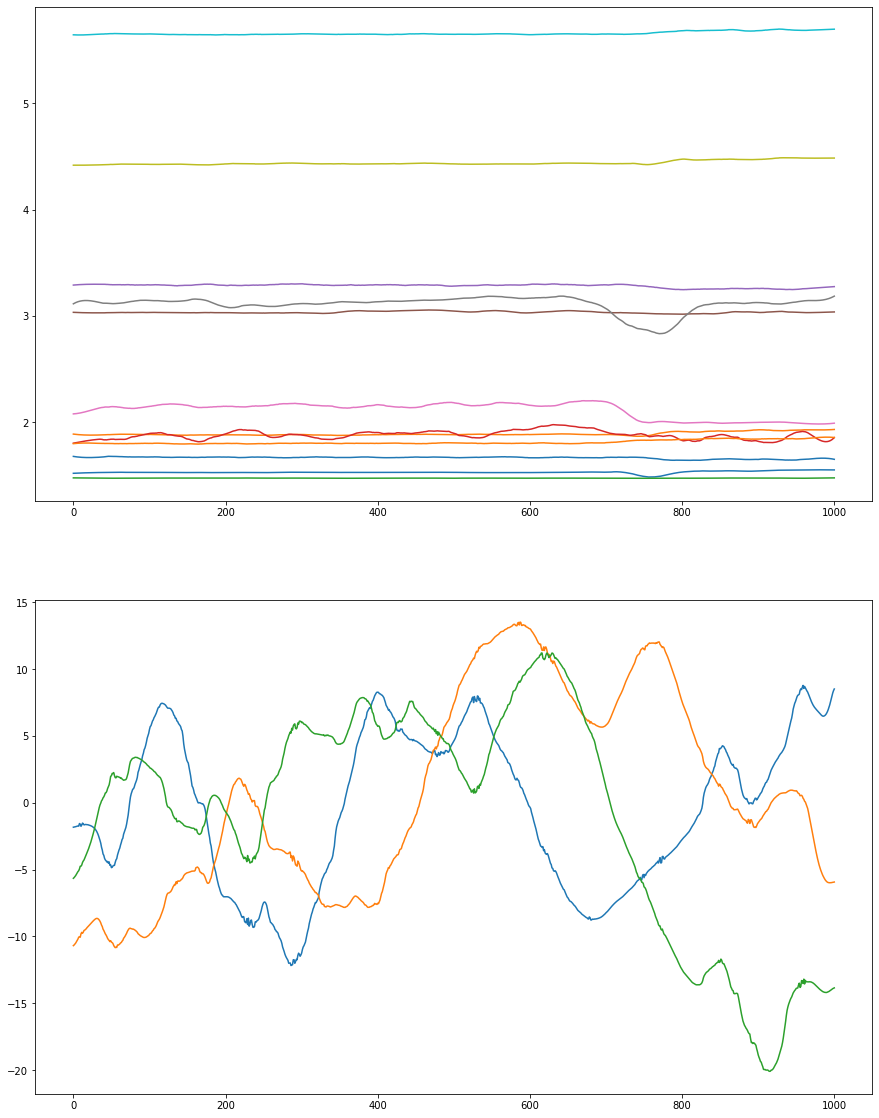

In [27]:
# Try TSNE
tsneFSR = deepcopy(fsrAndSlope)
tsne = TSNE(n_components = 3)
plt.figure(figsize=(15, 20))
plt.subplot(211)
plt.plot(fsrRefined[0])

plt.subplot(212)
for i in range(0, 56):
    tsneFSR[i] = tsne.fit_transform(tsneFSR[i])
plt.plot(tsneFSR[0])

In [40]:
# Run script on data

# Prepare data for algorithms
nsamples2, nx2, ny2 = np.shape(pcaFSR)
reformated_data2 = np.reshape(pcaFSR,(nsamples2, nx2*ny2))
[X_train2, X_test2, y_train2, y_test2] = train_test_split(reformated_data2, labels, random_state=0)

# Gaussian Naive-Bayes
model2 = GaussianNB().fit(X_train2, y_train2)
print(model2.score(X_train2, y_train2))
print(model2.score(X_test2, y_test2))
print("Predicted labels = " + str(model2.predict(X_test2)))
print("Correct labels =   " + str(y_test2))

0.9761904761904762
0.8571428571428571
Predicted labels = [4 3 3 2 1 1 3 4 4 3 1 1 1 4]
Correct labels =   [4 3 3 2 1 1 3 4 4 3 1 1 3 2]


In [31]:
# Random Forest
rf2 = RandomForestClassifier().fit(X_train2, y_train2)
print(rf2.score(X_train2, y_train2))
print(rf2.score(X_test2, y_test2))
print("Predicted labels = " + str(rf2.predict(X_test2)))
print("Correct labels =   " + str(y_test2))

1.0
0.7857142857142857
Predicted labels = [1 3 3 2 1 1 3 4 3 3 1 1 1 2]
Correct labels =   [4 3 3 2 1 1 3 4 4 3 1 1 3 2]


C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
